# TigerGraph Graph Data Science Library 101 - Graph Embedding 

This notebook shows the examples of using graph embedding algorithms in TigerGraph Graph Science Library. More detailed explanations of these algorithms can be four in the official documentation 
(https://docs.tigergraph.com/graph-ml/current/node-embeddings/).  

## Step 1: Load Cora graph data

In [3]:
import json
config_file = open ('config.json', "r")
config = json.load(config_file)
config_file.close()

In [4]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Cora")

Downloading:   0%|          | 0/166537 [00:00<?, ?it/s]

In [5]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('config.json', "r") as config_file:
    config = json.load(config_file)

conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"],
)

In [6]:
conn.ingestDataset(dataset, getToken=config["getToken"])

---- Checking database ----
A graph with name Cora already exists in the database. Please drop it first before ingesting.


In [7]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Step 2: Running Louvain Community Detection
We are going to use the pyTigerGraph featurizer to run Louvain community detection on the citation network.

In [8]:
feat = conn.gds.featurizer()

params = {
    "v_type_set": "Paper",
    "e_type_set": "Cite",
    "weight_attr": "",
    "max_iter": 10,
    "result_attribute": "community_id",
    "file_path": "",
    "print_stats": True
}

feat.runAlgorithm("tg_louvain", params = params)

[{'AllVertexCount': 2708},
 {'InitChangeCount': 0},
 {'VertexFollowedToCommunity': 371},
 {'VertexFollowedToVertex': 114},
 {'VertexAssignedToItself': 0},
 {'FinalCommunityCount': 2280}]

## Step 3: Leveraging pyTigerGraph’s featurizer to run embedding algorithms

pyTIgerGraph provides a full suit of data science capabilities, and in this tutorial, we will showcase how to use featurizer to run a few popular algorithms as an example.

In [9]:
feat.listAlgorithms("Embeddings")

Available algorithms for Embeddings:
  FastRP:
    01. name: tg_fastRP
Call runAlgorithm() with the algorithm name to execute it


### Install and run fastRP algorithm 

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data. (https://docs.tigergraph.com/graph-ml/current/node-embeddings/fast-random-projection)

In [10]:
'''
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='DEBUG'
import logging
logging.getLogger().setLevel(logging.DEBUG)
log = logging.getLogger()
log.debug('Test debug')
'''

"\n# workaround via specifying an invalid value first\n%config Application.log_level='WORKAROUND'\n# => fails, necessary on Fedora 27, ipython3 6.2.1\n%config Application.log_level='DEBUG'\nimport logging\nlogging.getLogger().setLevel(logging.DEBUG)\nlog = logging.getLogger()\nlog.debug('Test debug')\n"

In [11]:
params={"v_type": ["Paper"],
        "e_type": ["Cite"],
        "output_v_type": ["Paper"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

conn.runInstalledQuery("tg_fastRP", params=params, usePost=True)

[{'@@embedding_dim_map': {'default': {'min_dim': 0,
    'max_dim': 128,
    'weight': 1}}},
 {'sample_verts': []}]

In [12]:
df = conn.getVertexDataFrame("Paper")

In [13]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,community_id,embedding
0,2696,2696,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,18874394,"[0.20723, 0.0653, -0.22448, -0.00338, -0.03258..."
1,2649,2649,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,False,False,True,32505857,"[0.06817, 0.09705, -0.08061, -0.17636, 0.07553..."
2,2583,2583,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,28311622,"[0, -0.23814, 0, 0, 0.23814, 0.23814, -0.23814..."
3,2509,2509,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,32505859,"[-0.23339, -0.261, 0.25222, -0.28747, -0.13489..."
4,2486,2486,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,32505860,"[-0.33999, 0.14004, -0.13831, -0.14725, -0.012..."


In [14]:
import pandas as pd

pd.DataFrame(df['community_id'].value_counts()).value_counts().sort_index()

community_id
1               1925
2                314
3                 29
4                  7
5                  3
12                 1
13                 1
dtype: int64

### Compute intra- and inter-communities similarities for FastRP embeddings using Louvain Communities

In [15]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cnt = 5
comms_list = ['community_id']

for comm in comms_list:
    print(f"***Community Detection ID: {comm}***\n")
    
    comm_embs = None
    print("Intra-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs = np.stack(community["embedding"].values)
        similarities = cosine_similarity(comm_embs)
        print(f"Community: {i}")
        print(f"Number of members in community: {len(comm_embs)}")
        print(f"Mean intra-community similarity: {similarities.mean()}")
        print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
        print()

    print("Inter-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs_comp = comm_embs
        comm_embs = np.stack(community["embedding"].values)

        if i >= 1:
            similarities = cosine_similarity(comm_embs_comp, comm_embs)
            print(f"Communities: {i-1}-{i}")
            print(f"Mean inter-community similarity: {similarities.mean()}")
            print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
            print()

***Community Detection ID: community_id***

Intra-community similarities:

Community: 0
Number of members in community: 13
Mean intra-community similarity: 0.9956323966348748
Std. Dev. of intra-community similarity: 0.010735482595663044

Community: 1
Number of members in community: 12
Mean intra-community similarity: 0.9971309685016971
Std. Dev. of intra-community similarity: 0.006756221685053729

Community: 2
Number of members in community: 5
Mean intra-community similarity: 0.9981315169978298
Std. Dev. of intra-community similarity: 0.002723758625497433

Community: 3
Number of members in community: 5
Mean intra-community similarity: 0.9962851172553873
Std. Dev. of intra-community similarity: 0.00541532564470582

Community: 4
Number of members in community: 5
Mean intra-community similarity: 0.9886464492266961
Std. Dev. of intra-community similarity: 0.016550502098705008

Inter-community similarities:

Communities: 0-1
Mean inter-community similarity: -0.05688276737496215
Std. Dev. of

In [16]:
# Grab embeddings for Louvain Communities

c_id0 = df["community_id"].value_counts().head(25).index[0]
c_id1 = df["community_id"].value_counts().head(25).index[1]
c_id2 = df["community_id"].value_counts().head(25).index[2]
c_id3 = df["community_id"].value_counts().head(25).index[3]
c_id4 = df["community_id"].value_counts().head(25).index[4]

community0 = df[df["community_id"] == c_id0]
comm_embs0 = np.stack(community0["embedding"].values)

community1 = df[df["community_id"] == c_id1]
comm_embs1 = np.stack(community1["embedding"].values)

community2 = df[df["community_id"] == c_id2]
comm_embs2 = np.stack(community2["embedding"].values)

community3 = df[df["community_id"] == c_id3]
comm_embs3 = np.stack(community3["embedding"].values)

community4 = df[df["community_id"] == c_id4]
comm_embs4 = np.stack(community4["embedding"].values)

X = np.vstack((comm_embs0, comm_embs1, comm_embs2, comm_embs3, comm_embs4))

y0 = np.ones((comm_embs0.shape[0])) * 0
y1 = np.ones((comm_embs1.shape[0])) * 1
y2 = np.ones((comm_embs2.shape[0])) * 2
y3 = np.ones((comm_embs3.shape[0])) * 3
y4 = np.ones((comm_embs4.shape[0])) * 4
y = np.hstack((y0,y1,y2,y3,y4))

### Plot embeddings in 2D space

In [17]:
!pip install umap
!pip install umap-learn
!pip install seaborn

In [18]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(X)

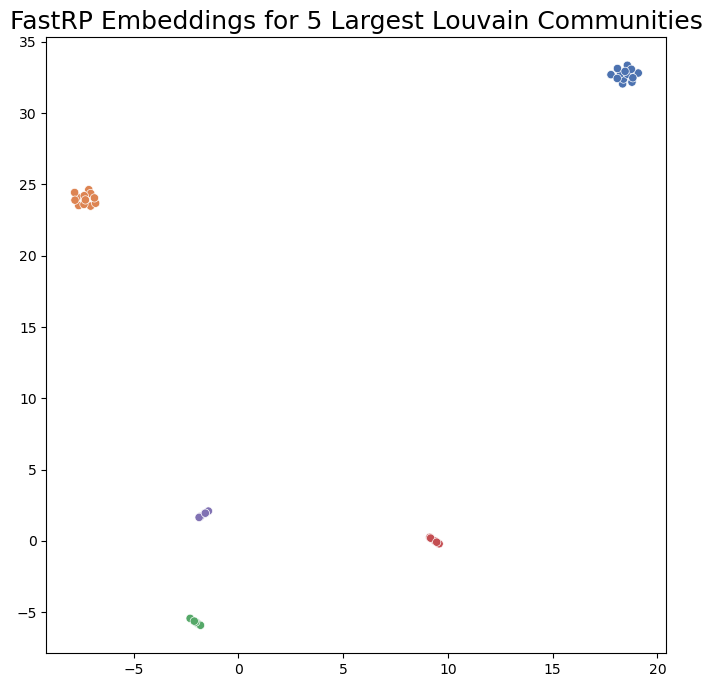

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2, 3, 4])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=y, palette=palette)
axs.get_legend().remove()
plt.title("FastRP Embeddings for 5 Largest Louvain Communities", fontsize=18)

plt.show()